# Indonesian Tweet Sentiment Analysis: ML vs DL Comparison

## Table of Contents
1. [Installation](#Installation)
2. [Setup and Imports](#Setup-and-Imports)
3. [Data Loading and Exploration](#Data-Loading-and-Exploration)
4. [Text Preprocessing](#Text-Preprocessing)
5. [Feature Engineering](#Feature-Engineering)
6. [Traditional ML Experiments](#Traditional-ML-Experiments)
7. [Deep Learning Experiments](#Deep-Learning-Experiments)
8. [Model Comparison](#Model-Comparison)
9. [Conclusions and Recommendations](#Conclusions-and-Recommendations)
10. [Exporting Results](#Exporting-Results)

# Installation

Install all dependencies

In [10]:
%pip install pexpect pandas numpy matplotlib seaborn nltk sastrawi scikit-learn tensorflow
!python -m nltk.downloader punkt

Note: you may need to restart the kernel to use updated packages.
/Users/nicoaudy/.local/share/uv/python/cpython-3.10.16-macos-x86_64-none/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /Users/nicoaudy/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Setup and Imports

Load all in one go

In [11]:
# Setup and imports cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.16.2


# Data Loading and Exploration

=== DATA LOADING AND EXPLORATION ===
Dataset shape: (1815, 3)
Columns: ['Unnamed: 0', 'sentimen', 'tweet']

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1815 non-null   int64 
 1   sentimen    1815 non-null   object
 2   tweet       1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB
None

=== Missing Values ===
Unnamed: 0    0
sentimen      0
tweet         0
dtype: int64

=== Sentiment Distribution ===
sentimen
positif    612
netral     607
negatif    596
Name: count, dtype: int64
Percentage distribution:
sentimen
positif    33.72
netral     33.44
negatif    32.84
Name: count, dtype: float64


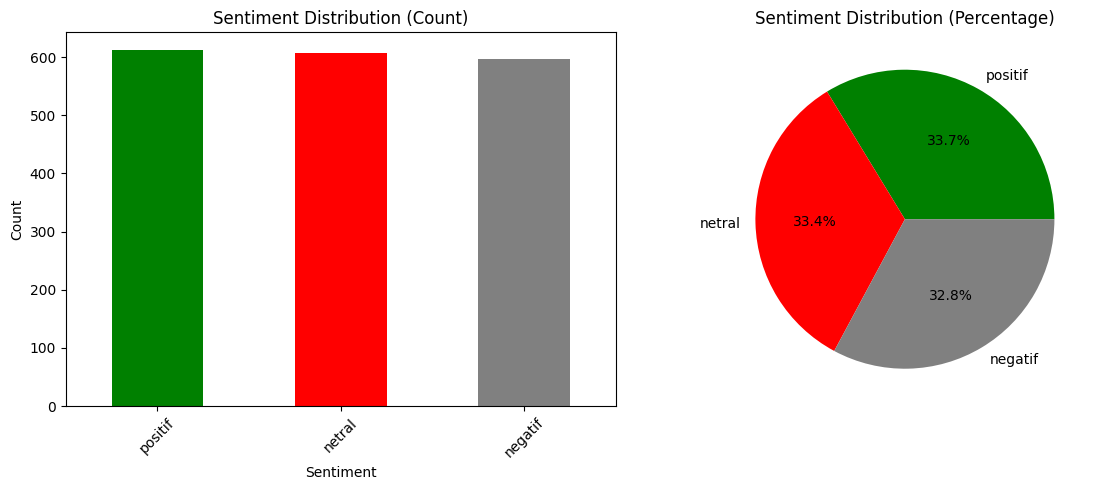


=== Sample Tweets ===

NEGATIF examples:
1. Kata @prabowo Indonesia tidak dihargai bangsa asing!   Berita ini ðŸ‘‡ pasti hoax buatan penguasa, y...
2. Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh...

NETRAL examples:
1. Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy?  http://dlvr.it/R2pvZVÂ ...
2. Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat ...

POSITIF examples:
1. Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. I...
2. Masa tenang msih ngoceh aja..ttp jokowi harga mati......


In [ ]:
# Data loading function
def load_and_explore_data(file_path=None):
    """Load CSV data and perform initial exploration"""
    print("=== DATA LOADING AND EXPLORATION ===")
    
    if file_path:
        # Load data from file
        df = pd.read_csv(file_path)
    else:
        # Create sample data
        sample_data = {
            'sentimen': ['negatif', 'netral', 'netral', 'positif', 'negatif', 'netral'] * 50,
            'tweet': [
                'Kata @prabowo Indonesia tidak dihargai bangsa asing! Berita ini pasti hoax buatan penguasa',
                'Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy?',
                'Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi',
                'Bagi Sumatera Selatan, Asian Games berdampak pd ekonomi langsung diprediksi mencapai 18,5 triliun. Indonesia maju, Jokowi hebat!',
                'Negara kita ngutang buat bngun infrastruktur yang udah dipake masyarakat, terus masyarakatnya ngeluh',
                'Yg bisikin pak jokowi, cm mikirin perputaran duit di golongan tertentu. E-Sports hanya sebagian kecil'
            ] * 50
        }
        df = pd.DataFrame(sample_data)
    
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Basic info
    print("\n=== Dataset Info ===")
    print(df.info())
    
    # Check for missing values
    print("\n=== Missing Values ===")
    print(df.isnull().sum())
    
    # Sentiment distribution
    print("\n=== Sentiment Distribution ===")
    sentiment_counts = df['sentimen'].value_counts()
    print(sentiment_counts)
    print(f"Percentage distribution:")
    print((sentiment_counts / len(df) * 100).round(2))
    
    # Plot sentiment distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
    plt.title('Sentiment Distribution (Count)')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
            colors=['green', 'red', 'gray'])
    plt.title('Sentiment Distribution (Percentage)')
    
    plt.tight_layout()
    plt.show()
    
    # Sample tweets
    print("\n=== Sample Tweets ===")
    for sentiment in df['sentimen'].unique():
        print(f"\n{sentiment.upper()} examples:")
        samples = df[df['sentimen'] == sentiment]['tweet'].head(2)
        for i, tweet in enumerate(samples, 1):
            print(f"{i}. {tweet[:100]}...")
    
    return df

# Load data
filepath = input("Enter the path to the data file: ")
df = load_and_explore_data(filepath)  # Using sample data

# Text Preprocessing

=== TEXT PREPROCESSING ANALYSIS ===
Preprocessing texts...

=== Text Statistics ===
            Original  Processed
Avg Length    194.67     113.22
Avg Words      24.93      17.31


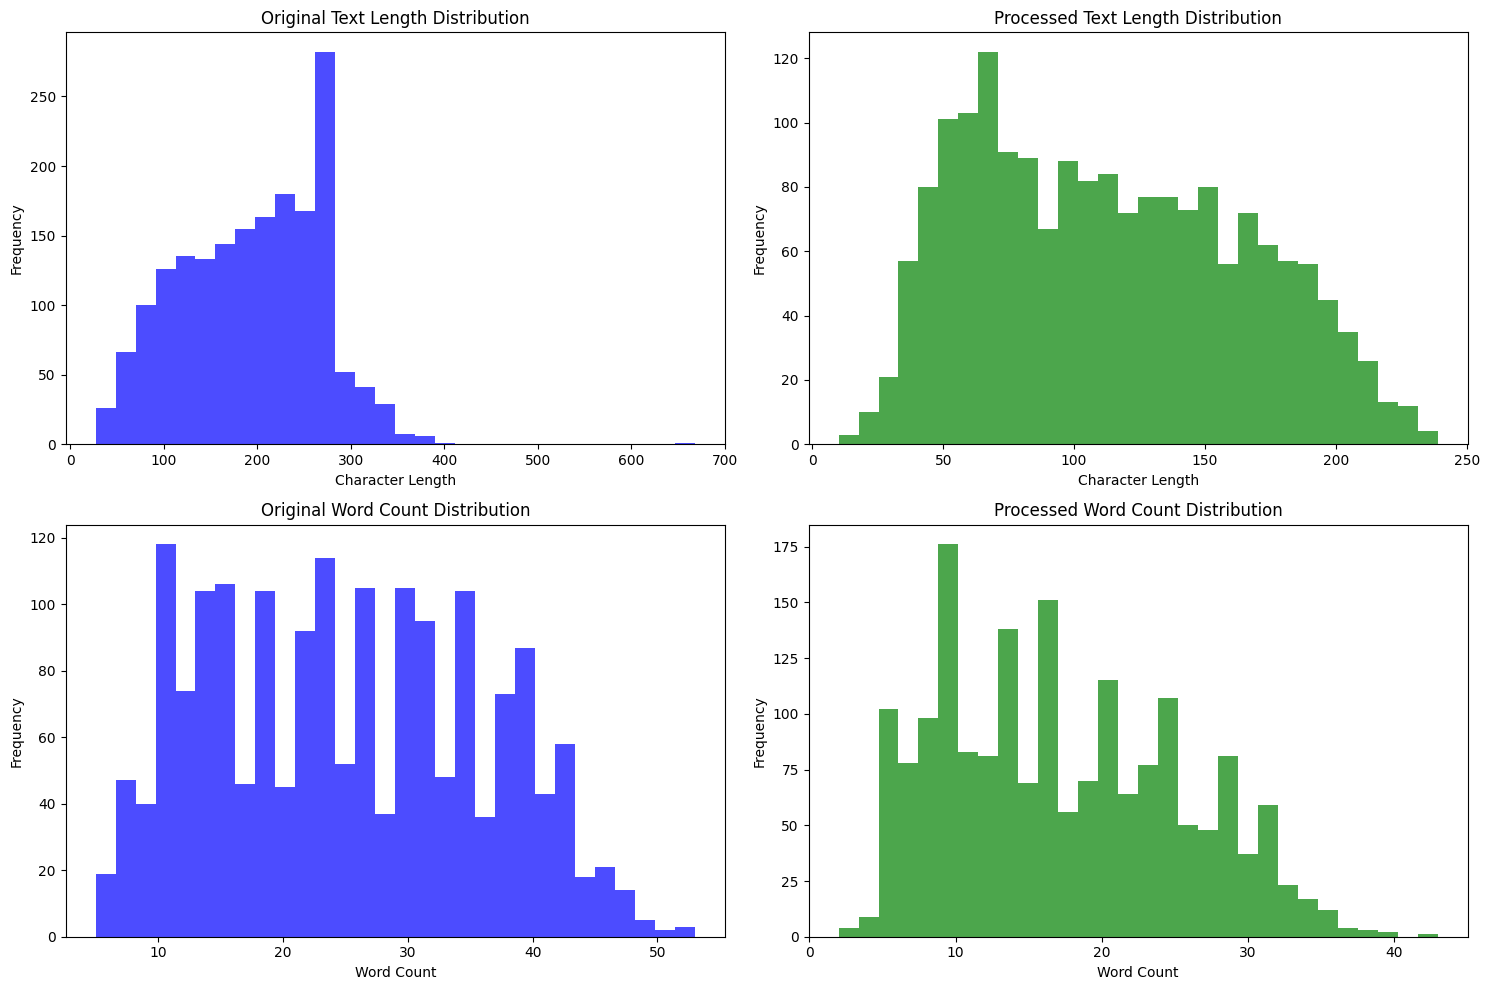


=== Preprocessing Examples ===

Example 1:
Original:  Kata @prabowo Indonesia tidak dihargai bangsa asing!   Berita ini ðŸ‘‡ pasti hoax buatan penguasa, y...
Processed: kata indonesia harga bangsa asing berita pasti hoax buat kuasa kan...

Example 2:
Original:  Batuan Langka, Tasbih Jokowi Hadiah dari Habib Luthfi Seharga Mercy?  http://dlvr.it/R2pvZVÂ ...
Processed: batu langka tasbih jokowi hadiah habib luthfi harga mercy...

Example 3:
Original:  Di era Jokowi, ekonomi Indonesia semakin baik. #01IndonesiaMaju #JokowiLagi #JokowiMenangTotalDebat ...
Processed: era jokowi ekonomi indonesia makin baik pictwittercomwythnxstp...


In [14]:
# Text preprocessing class
class IndonesianTextPreprocessor:
    def __init__(self):
        # Download required NLTK data
        try:
            nltk.data.find('tokenizers/punkt')
        except LookupError:
            nltk.download('punkt')
        
        # Initialize Indonesian-specific tools
        self.stemmer = StemmerFactory().create_stemmer()
        self.stopword_remover = StopWordRemoverFactory().create_stop_word_remover()
        
        # Additional Indonesian stopwords
        self.indonesian_stopwords = set([
            'yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 
            'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'itu',
            'dari', 'di', 'dengan', 'adalah', 'akan', 'atau', 'dalam', 'juga', 'sudah', 'dapat',
            'pak', 'bu', 'mas', 'mbak', 'bapak', 'ibu', 'saya', 'kami', 'kita', 'mereka'
        ])
    
    def clean_text(self, text):
        """Clean text: remove URLs, mentions, hashtags, special chars"""
        if pd.isna(text):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def preprocess_text(self, text):
        """Complete text preprocessing pipeline"""
        # Clean text
        text = self.clean_text(text)
        
        # Remove stopwords
        text = self.stopword_remover.remove(text)
        
        # Stem text
        text = self.stemmer.stem(text)
        
        # Remove custom stopwords
        words = text.split()
        words = [word for word in words if word not in self.indonesian_stopwords and len(word) > 2]
        
        return ' '.join(words)
    
    def analyze_text_stats(self, df, text_col='tweet'):
        """Analyze text statistics before and after preprocessing"""
        print("=== TEXT PREPROCESSING ANALYSIS ===")
        
        # Original text stats
        df['original_length'] = df[text_col].str.len()
        df['original_words'] = df[text_col].str.split().str.len()
        
        # Preprocess all texts
        print("Preprocessing texts...")
        df['cleaned_tweet'] = df[text_col].apply(self.preprocess_text)
        
        # Processed text stats
        df['processed_length'] = df['cleaned_tweet'].str.len()
        df['processed_words'] = df['cleaned_tweet'].str.split().str.len()
        
        # Statistics
        print("\n=== Text Statistics ===")
        stats_df = pd.DataFrame({
            'Original': [df['original_length'].mean(), df['original_words'].mean()],
            'Processed': [df['processed_length'].mean(), df['processed_words'].mean()]
        }, index=['Avg Length', 'Avg Words'])
        print(stats_df.round(2))
        
        # Visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Length distribution
        axes[0,0].hist(df['original_length'], bins=30, alpha=0.7, label='Original', color='blue')
        axes[0,0].set_title('Original Text Length Distribution')
        axes[0,0].set_xlabel('Character Length')
        axes[0,0].set_ylabel('Frequency')
        
        axes[0,1].hist(df['processed_length'], bins=30, alpha=0.7, label='Processed', color='green')
        axes[0,1].set_title('Processed Text Length Distribution')
        axes[0,1].set_xlabel('Character Length')
        axes[0,1].set_ylabel('Frequency')
        
        # Word count distribution
        axes[1,0].hist(df['original_words'], bins=30, alpha=0.7, label='Original', color='blue')
        axes[1,0].set_title('Original Word Count Distribution')
        axes[1,0].set_xlabel('Word Count')
        axes[1,0].set_ylabel('Frequency')
        
        axes[1,1].hist(df['processed_words'], bins=30, alpha=0.7, label='Processed', color='green')
        axes[1,1].set_title('Processed Word Count Distribution')
        axes[1,1].set_xlabel('Word Count')
        axes[1,1].set_ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        
        # Show examples
        print("\n=== Preprocessing Examples ===")
        for i in range(3):
            print(f"\nExample {i+1}:")
            print(f"Original:  {df.iloc[i]['tweet'][:100]}...")
            print(f"Processed: {df.iloc[i]['cleaned_tweet'][:100]}...")
        
        return df

# Initialize preprocessor and process data
preprocessor = IndonesianTextPreprocessor()
df = preprocessor.analyze_text_stats(df)

# Feature Engineering

In [ ]:
# Feature engineering function
def create_features(df):
    """Create various features for machine learning"""
    print("=== FEATURE ENGINEERING ===")
    
    # Text-based features
    df['char_count'] = df['cleaned_tweet'].str.len()
    df['word_count'] = df['cleaned_tweet'].str.split().str.len()
    df['avg_word_length'] = df['cleaned_tweet'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df['exclamation_count'] = df['tweet'].str.count('!')
    df['question_count'] = df['tweet'].str.count('\?')
    df['mention_count'] = df['tweet'].str.count('@')
    df['hashtag_count'] = df['tweet'].str.count('#')
    df['uppercase_ratio'] = df['tweet'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
    
    # Most common words by sentiment
    print("\n=== Most Common Words by Sentiment ===")
    for sentiment in df['sentimen'].unique():
        text = ' '.join(df[df['sentimen'] == sentiment]['cleaned_tweet'])
        words = text.split()
        common_words = Counter(words).most_common(10)
        print(f"\n{sentiment.upper()}:")
        for word, count in common_words:
            print(f"  {word}: {count}")
    
    # Feature correlation with sentiment
    feature_cols = ['char_count', 'word_count', 'avg_word_length', 'exclamation_count',
                   'question_count', 'mention_count', 'hashtag_count', 'uppercase_ratio']
    
    print("\n=== Feature Statistics by Sentiment ===")
    feature_stats = df.groupby('sentimen')[feature_cols].mean()
    print(feature_stats.round(3))
    
    return df, feature_cols

df, feature_cols = create_features(df)